In [169]:
import numpy as np
import complot
import matplotlib.pyplot as plt
import uproot3 as uproot
import ipanema
import pandas as pd
import math
import complot
from uncertainties import unumpy as unp
import uncertainties as unc

In [170]:
data = pd.concat(
[
  uproot.open(f"/scratch49/marcos.romero/sidecar/{y}/Bs2JpsiPhi/v2r0@LcosK.root")['DecayTree'].pandas.df(flatten=None) for y in (2015, 2016, 2017, 2018)
]
)
df = data # .query("X_M<1008")

In [143]:
data = uproot.open("/scratch08/marcos.romero/tuples/data/BsJpsiPhi_Data_2016_UpDown_20190123_tmva_cut58_sel_comb_sw_corrLb.root")["DecayTree"].pandas.df(flatten=None)
df = data # .query("X_M<1008")
df.eval("tagOSdec = tagos_dec_new", inplace=True)
df.eval("tagOSeta = tagos_eta_new", inplace=True)
df.eval("cosK = helcosthetaK", inplace=True)
df.eval("cosL = helcosthetaL", inplace=True)
df.eval("hphi = helphi", inplace=True)
df.eval("tagSSdec = B_SSKaonLatest_TAGDEC", inplace=True)
df.eval("tagSSeta = B_SSKaonLatest_TAGETA", inplace=True)

In [171]:
pars = ipanema.Parameters.load("output/params/physics_params/run2/Bs2JpsiPhi/v2r0bdt2@LcosK_auto_run2Dual_vgc_amsrd_simul3_amsrd_combined.json").valuesdict(False)
# pars['p0_os']  = 0.389
# pars['p1_os']  = 0.8486
# pars['p0_ss']  = 0.4325
# pars['p1_ss']  = 0.9241
# pars['dp0_os'] = 0.009
# pars['dp1_os'] = 0.0143
# pars['dp0_ss'] = 0
# pars['dp1_ss'] = 0

print(pars)
timeres = {"sigma_offset":  1.29700e-02, "sigma_slope": 8.44600e-01, "sigma_curvature":0}
print(timeres)

OrderedDict([('fSlon1', 0.4557026856843885), ('fSlon2', 0.03992445596517333), ('fSlon3', 0.0028841625055527234), ('fSlon4', 0.003178289933429951), ('fSlon5', 0.04925877288129037), ('fSlon6', 0.15070597110099176), ('fPlon', 0.5213980571389263), ('fPper', 0.24279611437776336), ('pSlon', 0), ('pPlon', -0.041126662546393966), ('pPpar', 0), ('pPper', 0), ('dSlon1', 1.9800316695205944), ('dSlon2', 1.6457885381928692), ('dSlon3', 1.0810140442135805), ('dSlon4', -0.17457238672137088), ('dSlon5', -0.6135157083821028), ('dSlon6', -0.9751715260740577), ('dPlon', 0), ('dPpar', 3.1431377812019443), ('dPper', 2.7855941004785088), ('lSlon', 1), ('lPlon', 1.0046965769670613), ('lPpar', 1), ('lPper', 1), ('Gd', 0.65789), ('DGs', 0.09594440496504864), ('DGsd', 0.011258329852771046), ('DM', 17.737823516644806), ('eta_os', 0.3602), ('eta_ss', 0.4167), ('p0_os', 0.38986810477060435), ('p1_os', 0.8456602998253557), ('p0_ss', 0.43968228176844526), ('p1_ss', 0.6731069545384176), ('dp0_os', 0.00900134082218433

In [172]:
def get_omega(eta, tag, p0, p1, p2, dp0, dp1, dp2, eta_bar):
  result = 0;
  result += (p0 + tag*0.5*dp0);
  result += (p1 + tag*0.5*dp1)*(eta - eta_bar);
  result += (p2 + tag*0.5*dp2)*(eta - eta_bar)*(eta - eta_bar);

  if result < 0.0:
      return 0
  return result
  
  
def get_omega_simon(eta, tag, p0, p1, p2, dp0, dp1, dp2, eta_bar):
     meas_omega = 0.5*(1.0-eta)
     ma = 0.99;
     mi = 0;
     omega = 0
     omega += (p0 + 0.5*tag*dp0)
     omega += (p1 + 0.5*tag*dp1) * (meas_omega - eta_bar)
     omega += (p2 + 0.5*tag*dp2) * (meas_omega - eta_bar)**2
     if (1. + eta * (1-2*omega)) == 0:
         return 0.5
     return omega

def calculate_fk(cosK, cosL, hphi):
  fk = []
  sinK   = np.sqrt(1. - cosK*cosK);
  sinL   = np.sqrt(1. - cosL*cosL);
  sinphi = np.sin(hphi);
  cosphi = np.cos(hphi);

  fk.append( cosK*cosK*sinL*sinL ) 
  fk.append( 0.5*sinK*sinK*(1.-cosphi*cosphi*sinL*sinL) )
  fk.append( 0.5*sinK*sinK*(1.-sinphi*sinphi*sinL*sinL) )
  fk.append( sinK*sinK*sinL*sinL*sinphi*cosphi )
  fk.append( np.sqrt(2.)*sinK*cosK*sinL*cosL*cosphi )
  fk.append( -np.sqrt(2.)*sinK*cosK*sinL*cosL*sinphi )
  fk.append( sinL*sinL/3. )
  fk.append( 2.*sinK*sinL*cosL*cosphi/np.sqrt(6.) )
  fk.append( -2.*sinK*sinL*cosL*sinphi/np.sqrt(6.) )
  fk.append( 2.*cosK*sinL*sinL/np.sqrt(3.) )
  return fk

In [196]:
weight_string = "sw"
tagging = "data"
asymmetry_plot_plus = []
asymmetry_plot_minus = []
tLL = 0.0
tUL = 2*np.pi / pars['DM']
num_bins = 5
lh_scale = 10
time_offset = 0.3
num_events = df.shape[0]
print("All events:", num_events)


for i in range(num_events):
    # weight
    wP = df[weight_string].iat[i]
    wM = df[weight_string].iat[i]

    # print(wP)
    tagOS = 0
    tagSS = 0
    dilutionOS = 0.0
    dilutionOSB = 0.0
    dilutionOSBbar = 0.0;
    dilutionSS = 0.0
    dilutionSSB = 0.0
    dilutionSSBbar = 0.0;

    if tagging == "perfect":
        tagSS = df['tagOSdec'].iat[i]
        tagOS = df['tagSSdec'].iat[i]
        dilutionOSB = 1
        dilutionSSB = 1
        dilutionOSBbar = 1
        dilutionSSBbar = 1
    else:
        tagOS = df['tagOSdec'].values[i]
        tagSS = df['tagSSdec'].values[i]
        omegaOSB = get_omega(df['tagOSeta'].iat[i], +1,    pars['p0_os'], pars['p1_os'], 0*pars['p1_os'], pars['dp0_os'], pars['dp1_os'], 0*pars['dp1_os'], pars['eta_os'])
        omegaOSBbar = get_omega(df['tagOSeta'].iat[i], -1, pars['p0_os'], pars['p1_os'], 0*pars['p1_os'], pars['dp0_os'], pars['dp1_os'], 0*pars['dp1_os'], pars['eta_os'])
        omegaSSB = get_omega(df['tagSSeta'].iat[i], +1,    pars['p0_ss'], pars['p1_ss'], 0*pars['p1_ss'], pars['dp0_ss'], pars['dp1_ss'], 0*pars['dp1_ss'], pars['eta_ss'])
        omegaSSBbar = get_omega(df['tagSSeta'].iat[i], -1, pars['p0_ss'], pars['p1_ss'], 0*pars['p1_ss'], pars['dp0_ss'], pars['dp1_ss'], 0*pars['dp1_ss'], pars['eta_ss'])
        # if i==0: print("omegaOSB", omegaOSB)
        # if i==0: print("omegaOSBar", omegaOSBbar)
        # if i==0: print("omegaSSB", omegaSSB)
        # if i==0: print("omegaSSBar", omegaSSBbar)
        dilutionOSB = 1 - 2 * omegaOSB
        dilutionSSB = 1 - 2 * omegaSSB
        dilutionOSBbar = 1 - 2 * omegaOSBbar
        dilutionSSBbar = 1 - 2 * omegaSSBbar

    # if i==0: print(tagOS, tagSS)
    frac  = ((1+tagOS*dilutionOSB)*(1+tagSS*dilutionSSB))
    frac /= ((1+tagOS*dilutionOSB)*(1+tagSS*dilutionSSB)+(1-tagOS*dilutionOSBbar)*(1-tagSS*dilutionSSBbar))
    # if i==0: print(wP, frac)
    wP *= frac;
    wM *= (1-frac);
    # 3. tagging dilution weight
    wM *= np.abs(frac-0.5)*2;
    wP *= np.abs(frac-0.5)*2;
    # if i==0: print(wP, wM, frac)
    # 4. time resolution dilution weight
    #f_res_1=1.0;
    #f_res_2=1.0;
    #sigma_1=1.0;
    #sigma_2=1.0;
    #sigma_3=1.0;
    #mu     =0.0;
    #if (opts->use_per_event_res)
    #{
    #  probs[k]->calc_per_event_res_params(params[k], events[k]->at(i), sigma_1, sigma_2, sigma_3, f_res_1, f_res_2, mu );
    #}
    sigma_t = df['sigmat'].iat[i]
    delta_t = timeres['sigma_offset'] + timeres['sigma_slope']*sigma_t + timeres['sigma_curvature']*sigma_t**2
    #delta_t = 1
    wP *= np.exp(-delta_t**2*pars['DM']/2.0)
    wM *= np.exp(-delta_t**2*pars['DM']/2.0)
    
    # angular weight
    AS = 0.1
    AP = 1 - AS
    fk = calculate_fk(df['cosK'].iat[i], df['cosL'].iat[i], df['hphi'].iat[i])
    _even = AP*pars['fPlon'] * fk[0] + AP*pars['fPper'] * fk[1]
    _odd = AP*pars['fPper'] * fk[2] + AS * fk[6]
    wP *= (_even - _odd) / (_even + _odd)
    wM *= (_even - _odd) / (_even + _odd)
    
    # if i<10: print("final", df['time'].iat[i], math.fmod(df['time'].iat[i] - time_offset, tUL), wP, wM)
    asymmetry_plot_plus.append([math.fmod(df['time'].iat[i] - time_offset, tUL), wP])
    asymmetry_plot_minus.append([math.fmod(df['time'].iat[i] - time_offset, tUL), wM])

asymmetry_plot_plus = np.array(asymmetry_plot_plus)
asymmetry_plot_minus = np.array(asymmetry_plot_minus)

# _plus = complot.hist(asymmetry_plot_plus[:,0], num_bins, weights=asymmetry_plot_plus[:,1], range=(tLL, tUL));
# _minus = complot.hist(asymmetry_plot_minus[:,0], num_bins, weights=asymmetry_plot_minus[:,1], range=(tLL, tUL));
# _plus = complot.hist(asymmetry_plot_plus[:,0], num_bins);
# _minus = complot.hist(asymmetry_plot_minus[:,0], num_bins);

_plus = complot.hist(asymmetry_plot_plus[:,0], num_bins, weights=asymmetry_plot_plus[:,1], range=(tLL, tUL));
_minus = complot.hist(asymmetry_plot_minus[:,0], num_bins, weights=asymmetry_plot_minus[:,1], range=(tLL, tUL));
_uplus = np.sqrt(complot.hist(asymmetry_plot_plus[:,0], num_bins, weights=asymmetry_plot_plus[:,1]**2, range=(tLL, tUL)).counts);
_uminus = np.sqrt(complot.hist(asymmetry_plot_minus[:,0], num_bins, weights=asymmetry_plot_minus[:,1]**2, range=(tLL, tUL)).counts);

All events: 586593


In [197]:
for i in range(num_bins):
    print(f"{_plus.bins[i]:.4f}  | {_plus.counts[i]:+.4f}  | {_minus.counts[i]:+.4f}")

0.0354  | +1695.2001  | +1682.5476
0.1063  | +1646.8308  | +1649.0501
0.1771  | +1554.5715  | +1584.4637
0.2480  | +1488.5701  | +1497.6137
0.3188  | +1419.4960  | +1419.7318


0.1169423896784711


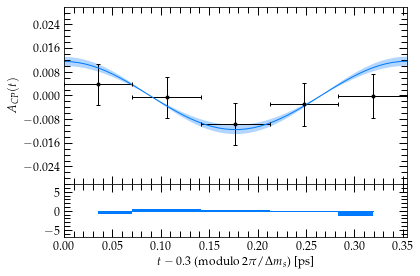

In [198]:
fig, axplot, axpull = complot.axes_plotpull()
__plus = unp.uarray(_plus.counts, _uplus)
__minus = unp.uarray(_minus.counts, _uminus)
asym = (__plus - __minus)/(__plus + __minus)
_t = np.linspace(0, tUL, 50) -0.0
avg_swave = np.mean([v for k,v in pars.items() if k.startswith('fS')])
avg_pwave = 1 - avg_swave
print(all_swave)
_eta_even = (avg_pwave*pars['fPlon'] + avg_pwave*pars['fPper'])
_eta_odd = (avg_pwave*(1-pars['fPlon']-pars['fPper']) + avg_swave*1)
_eta = (_eta_even- _eta_odd) / (_eta_even + _eta_odd)
_phis = unc.ufloat(0.8*pars['pPlon'], 0.0044)
_dg = unc.ufloat(pars['DGs'], 0.0080)
_dm = unc.ufloat(pars['DM'], 0.057)
_y = _eta * unp.sin(_phis) * unp.sin(_dm*(_t)-np.pi/2) / (unp.cosh(0.5*_dg*_t) - _eta * unp.cos(_phis) * unp.sinh(0.5*_dg*_t))

pulls = complot.compute_pdfpulls(_t, unp.nominal_values(_y), _plus.bins, unp.nominal_values(asym), unp.std_devs(asym), unp.std_devs(asym))
axpull.fill_between(_plus.bins, pulls, 0, step='mid')
axpull.plot(_plus.bins, _plus.bins*0, '-', color='C0')

axplot.plot(_t, unp.nominal_values(_y))
axplot.fill_between(_t,
  unp.nominal_values(_y)+unp.std_devs(_y),
  unp.nominal_values(_y)-unp.std_devs(_y),
  facecolor="C0",
  alpha=0.3)
axplot.errorbar(_plus.bins, unp.nominal_values(asym), yerr=(unp.std_devs(asym))**1, xerr=_plus.xerr, fmt='.', color='k')
axplot.set_ylim(-0.03, 0.03)
axplot.set_xlim(0, tUL)
axpull.set_xlabel("$t-0.3$ (modulo $2\pi/\Delta m_{s}$) [ps]")
axplot.set_ylabel("$A_{CP}(t)$")
fig.savefig("asymmetry_cp.pdf")

In [65]:
NBINS = 8
TIMEFRACS = [(float(it)/100.) for it in range(100)] # ['0.00', '0.50'] # ['0.00', '0.25', '0.50', '0.75']
ASYMMAX = 0.07 # plotting range
DELTAM = 17.70568
OSCPERIOD = 2. * np.pi / DELTAM
BINWIDTH = 2. * np.pi / DELTAM / float(NBINS)
BINOFFSET = 0.3 / BINWIDTH
PERIODSHIFT = -1.


[(1. + float(it) + BINOFFSET) / float(NBINS) * OSCPERIOD for it in range(NBINS)]

[0.3443585427612748,
 0.3887170855225496,
 0.4330756282838244,
 0.4774341710450992,
 0.521792713806374,
 0.5661512565676489,
 0.6105097993289237,
 0.6548683420901985]

In [168]:
pars['pPlon']

-0.041126662546393966